In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import torch  # type: ignore[import]
    import torch.nn as nn  # type: ignore[import]
    from torch.utils.data import TensorDataset, DataLoader, random_split  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "PyTorch is required for this notebook. Please install torch."
    ) from exc
try:
    from sklearn.preprocessing import MinMaxScaler  # type: ignore[import]
except ImportError as exc:
    raise ImportError(
        "scikit-learn is required for this notebook. Please install scikit-learn."
    ) from exc

torch.manual_seed(42)

import sys
root_dir = os.path.abspath("..")
if root_dir not in sys.path:
    sys.path.append(root_dir)
# print("Project root in sys.path:", root_dir)

from src.config import (
    CMAPSS_DATASETS,
    MAX_RUL,
    SEQUENCE_LENGTH,
    HIDDEN_SIZE,
    NUM_LAYERS,
    OUTPUT_SIZE,
    LEARNING_RATE,
    NUM_EPOCHS,
    GLOBAL_FEATURE_COLS,
    GLOBAL_DROP_COLS 
)

from src.data_loading import load_cmapps_subset
from src.additional_features import create_physical_features
from src.world_model_training import train_world_model_global

In [3]:
import importlib
import src.world_model_training as wmt
importlib.reload(wmt)

from src.data_loading import load_cmapps_global
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, GLOBAL_DROP_COLS
from src.world_model_training import(
    build_eol_tail_samples_from_df,
    create_tail_dataloaders,
    train_tail_lstm,
    verify_engine_based_split,
    )
import src.models.world_model as wmt
importlib.reload(wmt)
from src.models.world_model import WorldModelEncoderDecoderMultiTaskV9

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(
        fd_id,
        max_rul=None,       # oder max_rul=125, clip_train=False
        clip_train=False,   # KEIN Clipping im Train
        clip_test=True,     # Test gerne weiter clampen für NASA-Score
    )
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

# Samples bauen (gibt jetzt X, y, unit_ids zurück für engine-basierten Split)
X_tail, y_tail, unit_ids_tail = build_eol_tail_samples_from_df(
    df=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    max_rul_tail=125,  # Nur Sequenzen mit End-RUL <= 125
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

# WICHTIG: Engine-basierter Split um Daten-Leakage zu vermeiden
train_loader, val_loader = create_tail_dataloaders(
    X=X_tail,
    y=y_tail,
    val_ratio=0.2,
    batch_size=128,
    random_seed=42,
    unit_ids=unit_ids_tail,  # Für engine-basierten Split
    engine_based_split=True,  # WICHTIG: Verhindert Daten-Leakage
)

# Verifikation: Prüfe explizit, ob engine-basierter Split verwendet wurde
print("\n" + "=" * 60)
print("VERIFIKATION: Engine-basierter Split")
print("=" * 60)
verification = verify_engine_based_split(
    train_loader=train_loader,
    val_loader=val_loader,
    unit_ids=unit_ids_tail,
)
print("\n" + "=" * 60)
print("VERIFIKATIONS-ERGEBNIS:")
print("=" * 60)
print(f"Status: {verification['verification_status']}")
print(f"Split-Type: {verification['split_type']}")
if verification.get('has_data_leakage') is False:
    print("✓ KEINE Daten-Leakage - Val-Scores sind realistisch und unit-basiert")
elif verification.get('has_data_leakage') is True:
    print("⚠️  WARNUNG: Daten-Leakage erkannt - Val-Scores könnten zu optimistisch sein")
print("=" * 60)

# 3. Modell trainieren
model_tail_lstm, history_tail_lstm = train_tail_lstm(
    train_loader=train_loader,
    val_loader=val_loader,
    num_features=len(feature_cols),  # LSTM benötigt nur num_features, nicht seq_len
    hidden_dim=64,  # LSTM Default
    num_layers=2,  # LSTM Default
    bidirectional=False,  # LSTM Default
    device=device,
    num_epochs=80,  # LSTM Default
    lr=1e-4,  # Konservativer Default
    weight_decay=1e-4,  # L2-Regularisierung
    dropout=0.1,  # Geringes Dropout
    use_feature_scaling=True,  # Feature-Normalisierung (empfohlen)
    early_stopping_patience=8,  # Early Stopping
    use_lr_scheduler=True,  # LR Scheduler
    checkpoint_dir="../results/tail_eol_lstm",  # LSTM Checkpoint-Verzeichnis
)

Using device: cpu
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  191
1             0.943169        0.2       0.403406  190
2             0.942554       -1.8       0.404505  189
3             0.943025        0.2       0.405834  188
4             0.942581        1.2       0.405831  187
[build_eol_tail_samples_from_df] Summary
Num units: 100
Using past_len=30, max_rul_tail=125
Num feature cols: 24
X shape: torch.Size([12492, 30, 24]), y shape: torch.Size([12492]), unit_ids shape: torch.Size([12492])
RUL stats (tail): min=0.00, max=125.00, mean=62.03, std=36.17
[EOL-Tail] Engine-based split
Total units: 100
Train units: 80, Val units: 20
Train samples: 10003, Val samples: 2489

VERIFIKATION: Engine-basierter Split
[Engine-Based Split Verification]
[INFO] TensorDataset detected - checking via sample extraction...
[INFO] TensorDataset structure suggests engine-based split wa

[EOL-Tail Consistency Check]

[1] Split Consistency Check
------------------------------------------------------------
[Split Consistency Check]
[INFO] Cannot directly check split consistency from TensorDataset.
[INFO] If engine_based_split=True was used in create_tail_dataloaders,
[INFO] the split should be engine-based (no data leakage).
[INFO] For accurate check, use engine_based_split=True and provide unit_ids.

[2] Training Curves
------------------------------------------------------------
[Plot] Saved training curves to ../results/tail_eol_lstm\tail_eol_training_curves.png


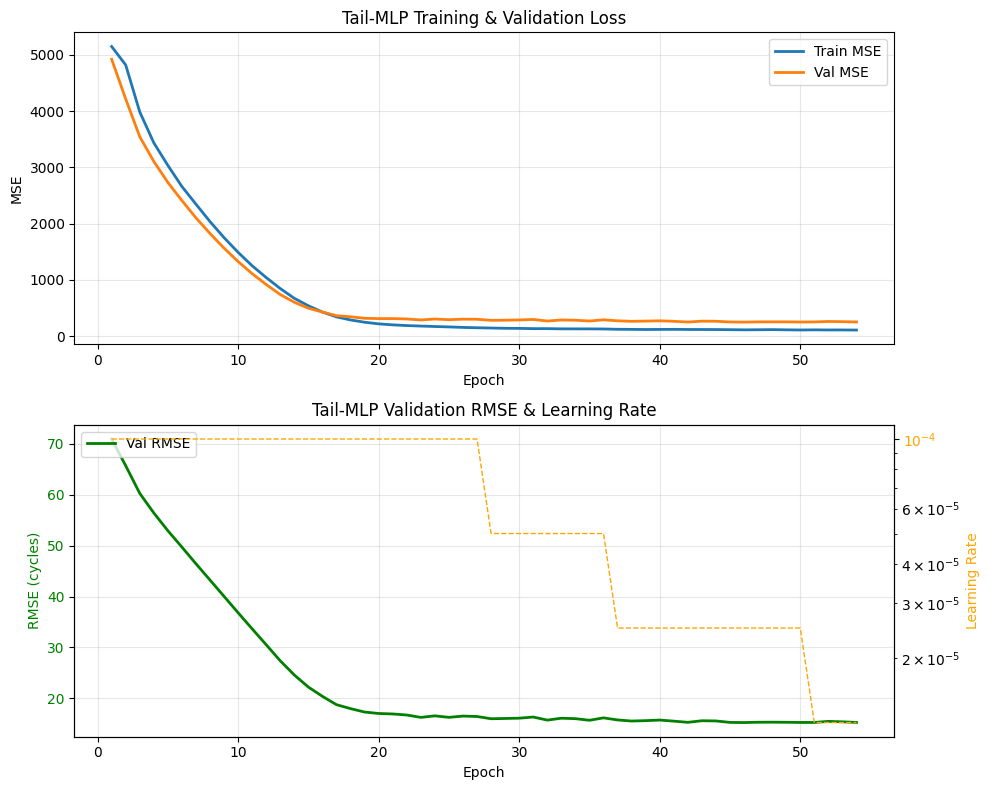


[3] Prediction Analysis
------------------------------------------------------------
[Plot] Saved predictions plot to ../results/tail_eol_lstm\tail_eol_predictions.png


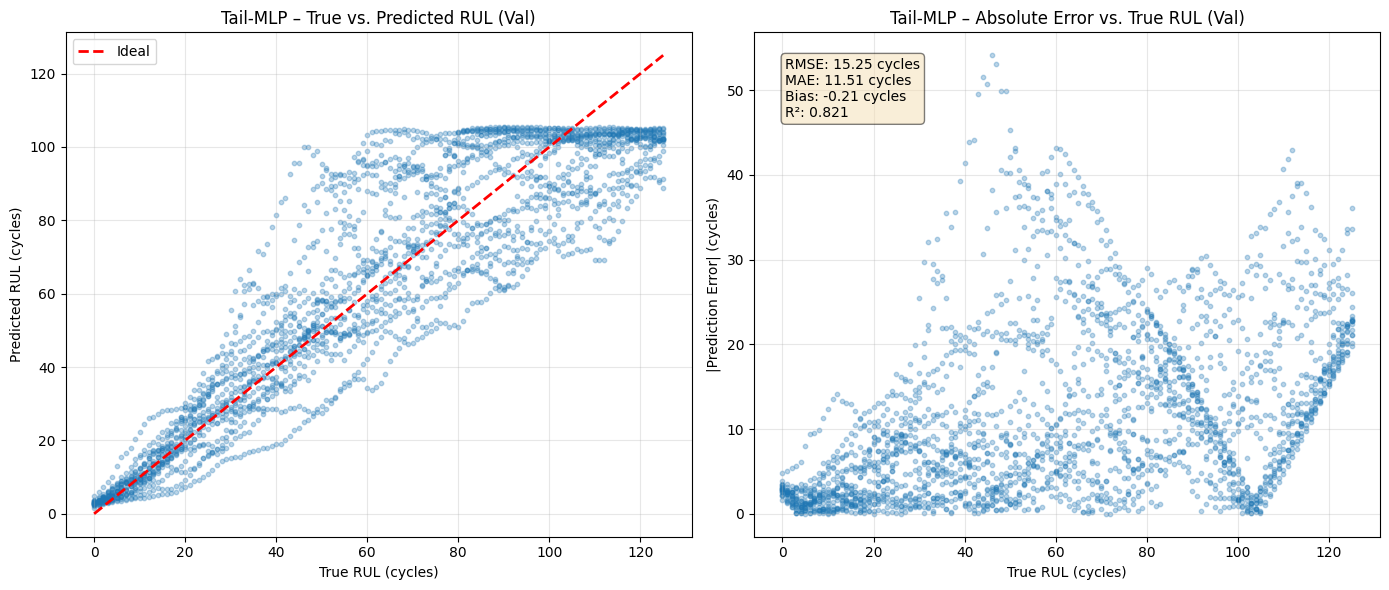

Val RMSE: 15.25 cycles
Val MAE: 11.51 cycles
Bias: -0.21 cycles
R²: 0.821

[4] Error Analysis by RUL Bin
------------------------------------------------------------
[EOL-Tail] RMSE & MAE per RUL Bin
[0,20)       - RMSE:   4.05 cycles, MAE:   2.95 cycles, Samples:   400
[20,40)      - RMSE:  10.55 cycles, MAE:   7.98 cycles, Samples:   400
[40,60)      - RMSE:  18.35 cycles, MAE:  13.26 cycles, Samples:   400
[60,80)      - RMSE:  18.70 cycles, MAE:  15.18 cycles, Samples:   400
[80,100)     - RMSE:  15.29 cycles, MAE:  13.49 cycles, Samples:   400
[100,125)    - RMSE:  17.83 cycles, MAE:  15.04 cycles, Samples:   473
[Plot] Saved error-by-bin plot to ../results/tail_eol_lstm\tail_eol_error_by_bin.png


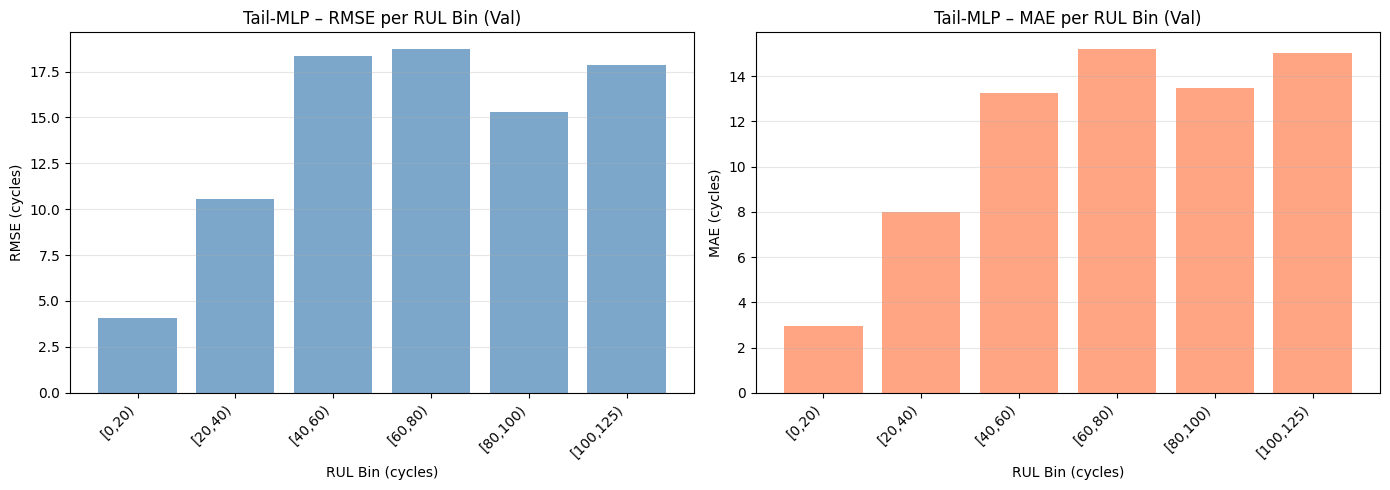


[EOL-Tail Consistency Check] Summary
Split Type: unknown - TensorDataset
Val RMSE: 15.25 cycles
Val MAE: 11.51 cycles
Bias: -0.21 cycles
R²: 0.821

KONSISTENZ-CHECK ZUSAMMENFASSUNG (LSTM)
✓ Split-Type: unknown - TensorDataset
✓ Val RMSE: 15.25 cycles
✓ Val MAE: 11.51 cycles
✓ Bias: -0.21 cycles
✓ R²: 0.821


In [4]:
# ===================================================================
# Konsistenz-Check: Umfassende Analyse des trainierten Modells
# ===================================================================

from src.world_model_training import (
    evaluate_tail_eol_consistency,
    plot_tail_eol_training_curves,
    plot_tail_eol_predictions,
    plot_tail_eol_error_by_rul_bin,
    check_split_consistency,
)

# Scaler aus dem LSTM-Modell holen (falls vorhanden)
scaler_lstm = getattr(model_tail_lstm, 'scaler', None)

# Umfassender Konsistenz-Check mit allen Plots für LSTM
consistency_results_lstm = evaluate_tail_eol_consistency(
    model=model_tail_lstm,
    train_loader=train_loader,
    val_loader=val_loader,
    history=history_tail_lstm,
    scaler=scaler_lstm,
    device=device,
    unit_ids=unit_ids_tail,  # Für Split-Consistency-Check
    plot=True,
    save_dir="../results/tail_eol_lstm",  # LSTM Plots speichern
)

# Ergebnisse ausgeben (LSTM)
print("\n" + "=" * 60)
print("KONSISTENZ-CHECK ZUSAMMENFASSUNG (LSTM)")
print("=" * 60)
print(f"✓ Split-Type: {consistency_results_lstm['split_check'].get('split_type', 'unknown')}")
if consistency_results_lstm['split_check'].get('has_data_leakage') is True:
    print(f"⚠️  WARNUNG: Daten-Leakage erkannt!")
    print(f"   {consistency_results_lstm['split_check'].get('overlapping_units', 0)} Engines in Train UND Val")
elif consistency_results_lstm['split_check'].get('has_data_leakage') is False:
    print("✓ Keine Daten-Leakage - Split ist engine-basiert")
print(f"✓ Val RMSE: {consistency_results_lstm['predictions']['rmse']:.2f} cycles")
print(f"✓ Val MAE: {consistency_results_lstm['predictions']['mae']:.2f} cycles")
print(f"✓ Bias: {consistency_results_lstm['predictions']['bias']:.2f} cycles")
print(f"✓ R²: {consistency_results_lstm['predictions']['r2']:.3f}")
print("=" * 60)


In [ ]:
# ===================================================================
# Tail-LSTM Training: LSTM-basierter EOL-Regressor
# ===================================================================

from src.world_model_training import (
    build_eol_tail_samples_from_df,
    create_tail_dataloaders,
    train_tail_lstm,
    verify_engine_based_split,
)

# Verwende die gleichen Daten wie für Tail-MLP
# (X_tail, y_tail, unit_ids_tail wurden bereits erstellt)

# WICHTIG: Engine-basierter Split um Daten-Leakage zu vermeiden
train_loader_lstm, val_loader_lstm = create_tail_dataloaders(
    X=X_tail,
    y=y_tail,
    val_ratio=0.2,
    batch_size=128,
    random_seed=42,
    unit_ids=unit_ids_tail,  # Für engine-basierten Split
    engine_based_split=True,  # WICHTIG: Verhindert Daten-Leakage
)

# Verifikation: Prüfe explizit, ob engine-basierter Split verwendet wurde
print("\n" + "=" * 60)
print("VERIFIKATION: Engine-basierter Split (LSTM)")
print("=" * 60)
verification_lstm = verify_engine_based_split(
    train_loader=train_loader_lstm,
    val_loader=val_loader_lstm,
    unit_ids=unit_ids_tail,
)
print("\n" + "=" * 60)
print("VERIFIKATIONS-ERGEBNIS (LSTM):")
print("=" * 60)
print(f"Status: {verification_lstm['verification_status']}")
print(f"Split-Type: {verification_lstm['split_type']}")
if verification_lstm.get('has_data_leakage') is False:
    print("✓ KEINE Daten-Leakage - Val-Scores sind realistisch und unit-basiert")
elif verification_lstm.get('has_data_leakage') is True:
    print("⚠️  WARNUNG: Daten-Leakage erkannt - Val-Scores könnten zu optimistisch sein")
print("=" * 60)

# LSTM-Modell trainieren
model_tail_lstm, history_tail_lstm = train_tail_lstm(
    train_loader=train_loader_lstm,
    val_loader=val_loader_lstm,
    num_features=len(feature_cols),
    hidden_dim=64,
    num_layers=2,
    bidirectional=False,
    device=device,
    num_epochs=80,
    lr=1e-4,
    weight_decay=1e-4,
    dropout=0.1,
    use_feature_scaling=True,  # Feature-Normalisierung (empfohlen)
    early_stopping_patience=8,  # Early Stopping
    use_lr_scheduler=True,  # LR Scheduler
    checkpoint_dir="../results/tail_eol_lstm",  # Optional: Checkpoint speichern
)


In [5]:
import importlib
import src.world_model_training as wmt
importlib.reload(wmt)

from src.data_loading import load_cmapps_global
from src.additional_features import create_physical_features
from src.config import GLOBAL_FEATURE_COLS, GLOBAL_DROP_COLS
from src.world_model_training import(
    build_eol_tail_samples_from_df,
    create_tail_dataloaders,
    train_tail_lstm,
    verify_engine_based_split,
    )
import src.models.world_model as wmt
importlib.reload(wmt)
from src.models.world_model import WorldModelEncoderDecoderMultiTaskV9

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1) globale Trainingsdaten bauen (Pseudo-Code, an deine Signaturen anpassen)
dfs = []
for fd_id in ["FD001","FD002", "FD003", "FD004"]: #, "FD002", "FD003", "FD004"
    df_train, _, _ = load_cmapps_subset(
        fd_id,
        max_rul=None,       # oder max_rul=125, clip_train=False
        clip_train=False,   # KEIN Clipping im Train
        clip_test=True,     # Test gerne weiter clampen für NASA-Score
    )
    df_train = create_physical_features(df_train)
    df_train["FD_ID"] = fd_id
    dfs.append(df_train)

df_train_global = pd.concat(dfs, ignore_index=True)

# 2) Featureliste definieren (wie beim globalen LSTM)
numeric_cols = df_train_global[GLOBAL_FEATURE_COLS].select_dtypes(
    include=["number"]
).columns.tolist()
feature_cols = numeric_cols

# Samples bauen (gibt jetzt X, y, unit_ids zurück für engine-basierten Split)
X_tail, y_tail, unit_ids_tail = build_eol_tail_samples_from_df(
    df=df_train_global,
    feature_cols=feature_cols,
    past_len=30,
    max_rul_tail=125,  # Nur Sequenzen mit End-RUL <= 125
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
    rul_col="RUL",
)

# WICHTIG: Engine-basierter Split um Daten-Leakage zu vermeiden
train_loader, val_loader = create_tail_dataloaders(
    X=X_tail,
    y=y_tail,
    val_ratio=0.2,
    batch_size=128,
    random_seed=42,
    unit_ids=unit_ids_tail,  # Für engine-basierten Split
    engine_based_split=True,  # WICHTIG: Verhindert Daten-Leakage
)

# Verifikation: Prüfe explizit, ob engine-basierter Split verwendet wurde
print("\n" + "=" * 60)
print("VERIFIKATION: Engine-basierter Split")
print("=" * 60)
verification = verify_engine_based_split(
    train_loader=train_loader,
    val_loader=val_loader,
    unit_ids=unit_ids_tail,
)
print("\n" + "=" * 60)
print("VERIFIKATIONS-ERGEBNIS:")
print("=" * 60)
print(f"Status: {verification['verification_status']}")
print(f"Split-Type: {verification['split_type']}")
if verification.get('has_data_leakage') is False:
    print("✓ KEINE Daten-Leakage - Val-Scores sind realistisch und unit-basiert")
elif verification.get('has_data_leakage') is True:
    print("⚠️  WARNUNG: Daten-Leakage erkannt - Val-Scores könnten zu optimistisch sein")
print("=" * 60)

# 3. Modell trainieren
model_tail_lstm, history_tail_lstm = train_tail_lstm(
    train_loader=train_loader,
    val_loader=val_loader,
    num_features=len(feature_cols),  # LSTM benötigt nur num_features, nicht seq_len
    hidden_dim=64,  # LSTM Default
    num_layers=2,  # LSTM Default
    bidirectional=False,  # LSTM Default
    device=device,
    num_epochs=80,  # LSTM Default
    lr=1e-4,  # Konservativer Default
    weight_decay=1e-4,  # L2-Regularisierung
    dropout=0.1,  # Geringes Dropout
    use_feature_scaling=True,  # Feature-Normalisierung (empfohlen)
    early_stopping_patience=8,  # Early Stopping
    use_lr_scheduler=True,  # LR Scheduler
    checkpoint_dir="../results/tail_eol_lstm",  # LSTM Checkpoint-Verzeichnis
)

Using device: cpu
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.941013        0.2       0.403737  191
1             0.943169        0.2       0.403406  190
2             0.942554       -1.8       0.404505  189
3             0.943025        0.2       0.405834  188
4             0.942581        1.2       0.405831  187
[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
New columns successfully added. Current number of columns: 33
   Effizienz_HPC_Proxy  EGT_Drift  Fan_HPC_Ratio  RUL
0             0.940506        6.8       0.408741  148
1             0.941593        2.8       0.406364  147
2             0.934608      -18.2       0.427536  146
3             0.944099        1.8       0.405833  145
4             0.938646      -18.2       0.427022  144
New columns successfully added. Current numbe

[EOL-Tail Consistency Check]

[1] Split Consistency Check
------------------------------------------------------------
[Split Consistency Check]
[INFO] Cannot directly check split consistency from TensorDataset.
[INFO] If engine_based_split=True was used in create_tail_dataloaders,
[INFO] the split should be engine-based (no data leakage).
[INFO] For accurate check, use engine_based_split=True and provide unit_ids.

[2] Training Curves
------------------------------------------------------------
[Plot] Saved training curves to ../results/tail_eol_lstm\tail_eol_training_curves.png


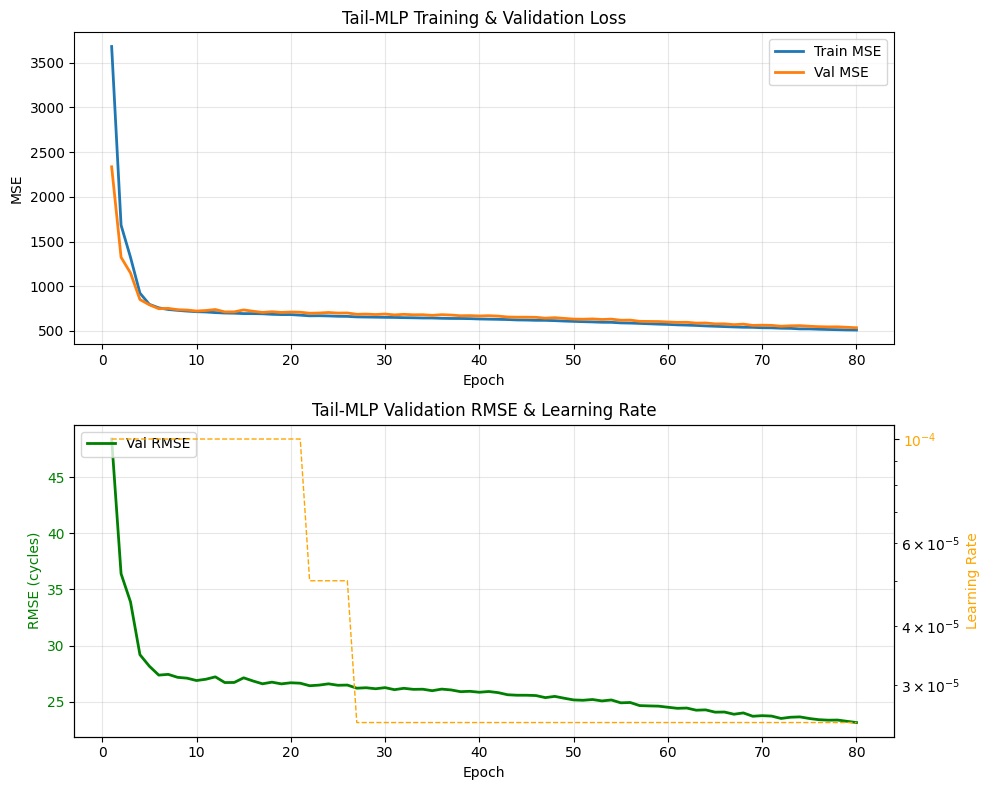


[3] Prediction Analysis
------------------------------------------------------------
[Plot] Saved predictions plot to ../results/tail_eol_lstm\tail_eol_predictions.png


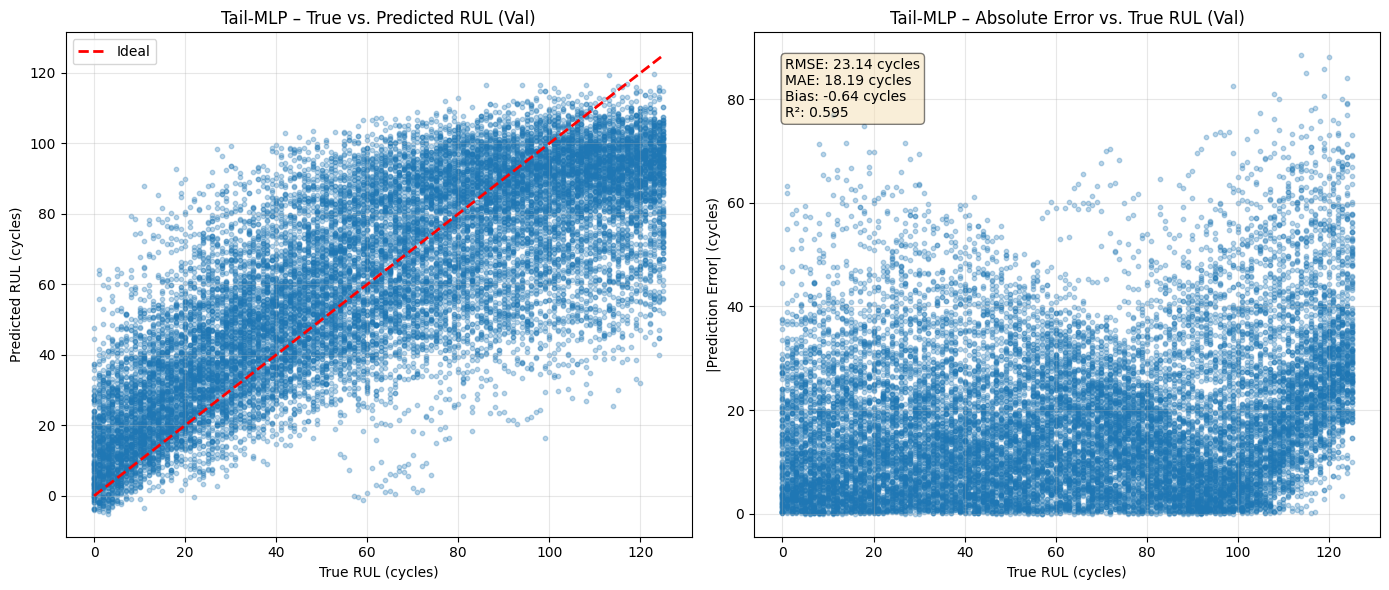

Val RMSE: 23.14 cycles
Val MAE: 18.19 cycles
Bias: -0.64 cycles
R²: 0.595

[4] Error Analysis by RUL Bin
------------------------------------------------------------
[EOL-Tail] RMSE & MAE per RUL Bin
[0,20)       - RMSE:  19.75 cycles, MAE:  14.92 cycles, Samples:  2940
[20,40)      - RMSE:  21.91 cycles, MAE:  17.06 cycles, Samples:  2940
[40,60)      - RMSE:  20.78 cycles, MAE:  16.55 cycles, Samples:  2940
[60,80)      - RMSE:  19.81 cycles, MAE:  16.37 cycles, Samples:  2940
[80,100)     - RMSE:  20.78 cycles, MAE:  15.66 cycles, Samples:  2940
[100,125)    - RMSE:  30.69 cycles, MAE:  25.82 cycles, Samples:  3664
[Plot] Saved error-by-bin plot to ../results/tail_eol_lstm\tail_eol_error_by_bin.png


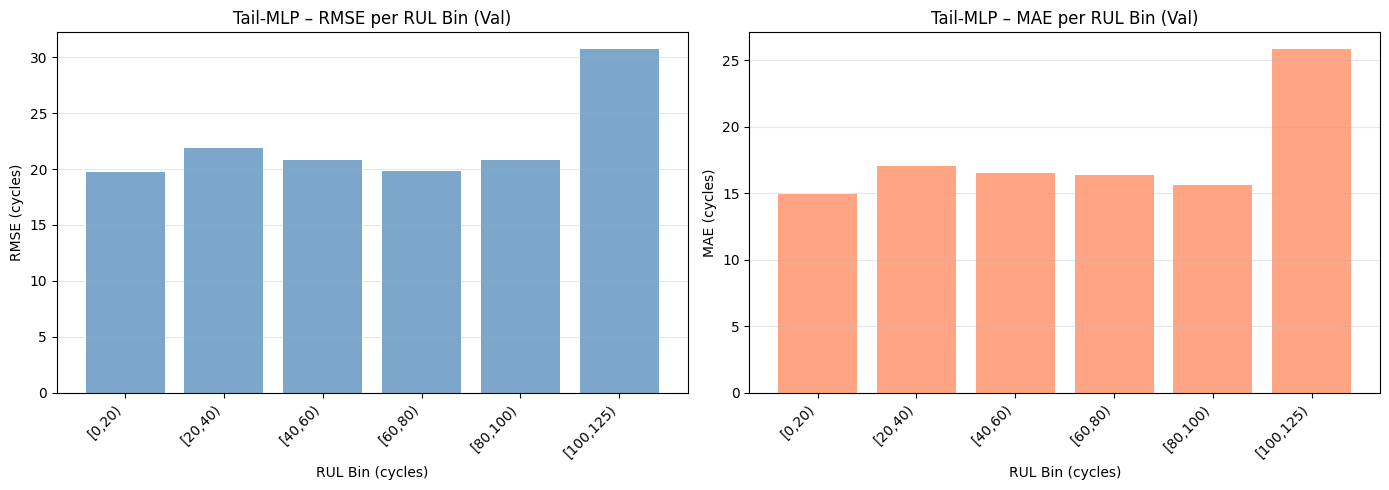


[EOL-Tail Consistency Check] Summary
Split Type: unknown - TensorDataset
Val RMSE: 23.14 cycles
Val MAE: 18.19 cycles
Bias: -0.64 cycles
R²: 0.595

KONSISTENZ-CHECK ZUSAMMENFASSUNG (LSTM)
✓ Split-Type: unknown - TensorDataset
✓ Val RMSE: 23.14 cycles
✓ Val MAE: 18.19 cycles
✓ Bias: -0.64 cycles
✓ R²: 0.595


In [7]:
# ===================================================================
# Konsistenz-Check: Umfassende Analyse des trainierten Modells
# ===================================================================

from src.world_model_training import (
    evaluate_tail_eol_consistency,
    plot_tail_eol_training_curves,
    plot_tail_eol_predictions,
    plot_tail_eol_error_by_rul_bin,
    check_split_consistency,
)

# Scaler aus dem LSTM-Modell holen (falls vorhanden)
scaler_lstm = getattr(model_tail_lstm, 'scaler', None)

# Umfassender Konsistenz-Check mit allen Plots für LSTM
consistency_results_lstm = evaluate_tail_eol_consistency(
    model=model_tail_lstm,
    train_loader=train_loader,
    val_loader=val_loader,
    history=history_tail_lstm,
    scaler=scaler_lstm,
    device=device,
    unit_ids=unit_ids_tail,  # Für Split-Consistency-Check
    plot=True,
    save_dir="../results/tail_eol_lstm",  # LSTM Plots speichern
)

# Ergebnisse ausgeben (LSTM)
print("\n" + "=" * 60)
print("KONSISTENZ-CHECK ZUSAMMENFASSUNG (LSTM)")
print("=" * 60)
print(f"✓ Split-Type: {consistency_results_lstm['split_check'].get('split_type', 'unknown')}")
if consistency_results_lstm['split_check'].get('has_data_leakage') is True:
    print(f"⚠️  WARNUNG: Daten-Leakage erkannt!")
    print(f"   {consistency_results_lstm['split_check'].get('overlapping_units', 0)} Engines in Train UND Val")
elif consistency_results_lstm['split_check'].get('has_data_leakage') is False:
    print("✓ Keine Daten-Leakage - Split ist engine-basiert")
print(f"✓ Val RMSE: {consistency_results_lstm['predictions']['rmse']:.2f} cycles")
print(f"✓ Val MAE: {consistency_results_lstm['predictions']['mae']:.2f} cycles")
print(f"✓ Bias: {consistency_results_lstm['predictions']['bias']:.2f} cycles")
print(f"✓ R²: {consistency_results_lstm['predictions']['r2']:.3f}")
print("=" * 60)
